## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---
## Camera calibration using chessboard images
%matplotlib qt
%matplotlib inline

Could not use ./camera_cal/calibration1.jpg for calibration.
Could not use ./camera_cal/calibration5.jpg for calibration.
Could not use ./camera_cal/calibration4.jpg for calibration.


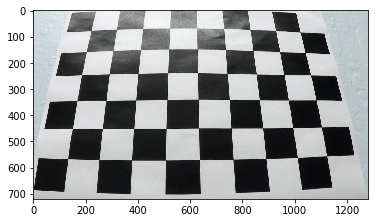

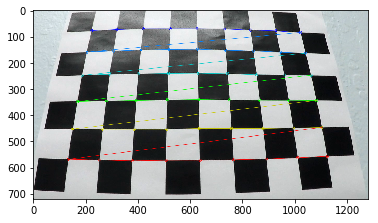

In [1]:
%matplotlib qt
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        imgWithCorners = cv2.drawChessboardCorners(np.copy(img), (9,6), corners, ret)
        
        # Handpicked example to show chessboard corner detection
        if fname == './camera_cal/calibration3.jpg':
            plt.figure()
            plt.imshow(img)
            plt.figure()
            plt.imshow(imgWithCorners)
            
    else:
        print('Could not use ' + fname + ' for calibration.')

## Distortion Correction

In [2]:
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def undistortImage(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

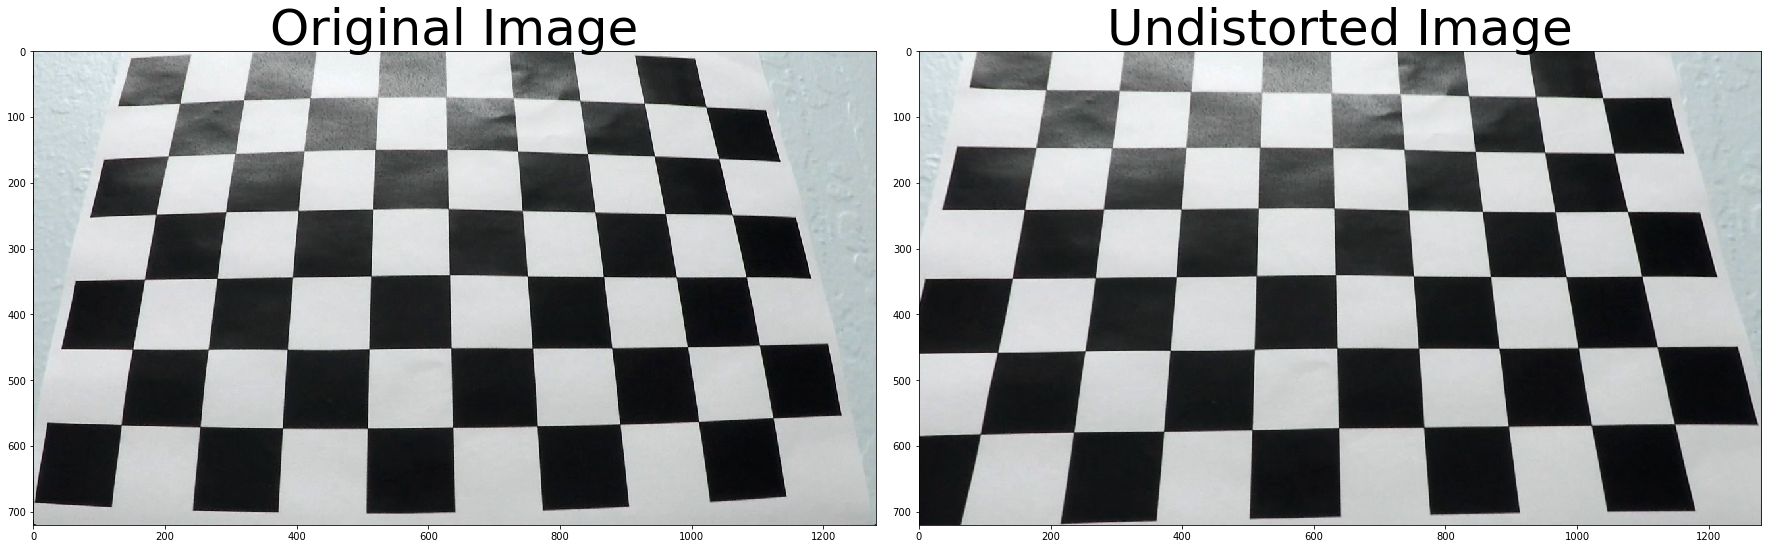

In [3]:
# Chessboard corrected example
img = cv2.imread('./camera_cal/calibration3.jpg');

undistorted = undistortImage(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


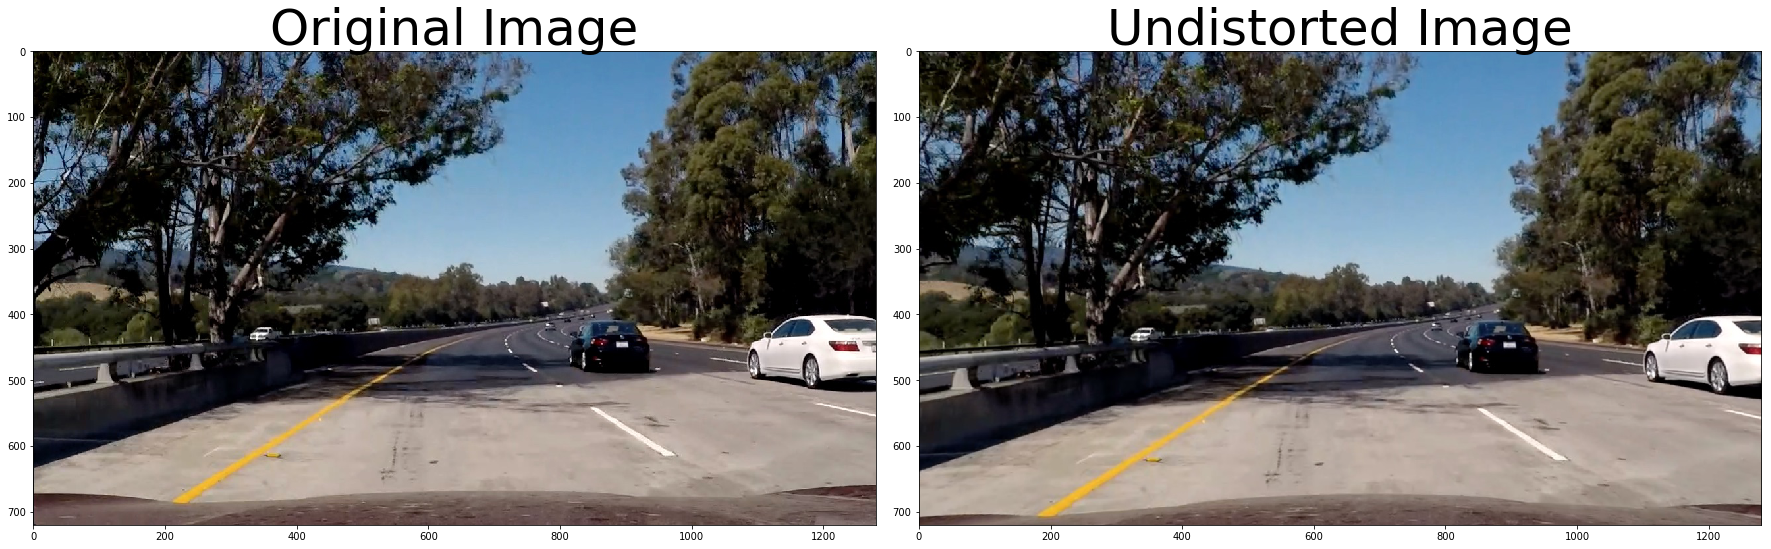

In [4]:
# Regular road image corrected example
img = cv2.imread('./test_images/test5.jpg');

undistorted = undistortImage(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Binary Image Creation

In [5]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [6]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [7]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

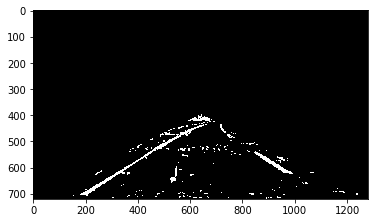

In [8]:
 tmp = np.copy(undistorted)

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# comment ehre

hlsTune = hls_select(tmp, thresh=(170, 255))

image = tmp

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', thresh_min=5, thresh_max=100)
grady = abs_sobel_thresh(image, orient='y', thresh_min=2, thresh_max=100)

mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

combined = np.zeros_like(gradx)

#coment tmp2
combined[(gradx == 1) & (grady == 1) | ((mag_binary == 1) & (dir_binary == 1)) | ((hlsTune == 1))] = 255


median = cv2.medianBlur(combined, 5)

combined = np.copy(median)
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Region of interest
imgShape = combined.shape


#todo maybe not harcode later
# Target: bottom left
v1 = (0, imgShape[0])

# Target: top center
v2 = ((imgShape[1] / 2), (imgShape[0] * 0.55))

# Target: bottom right
v4 = (imgShape[1], imgShape[0])

vertices = np.array([[v1,v2,v4]], dtype=np.int32)
# Region mask applied on the canny image
regionImg = region_of_interest(combined, vertices)

combined = np.copy(regionImg)

plt.imshow(combined, cmap='gray')

## Perspective Transform

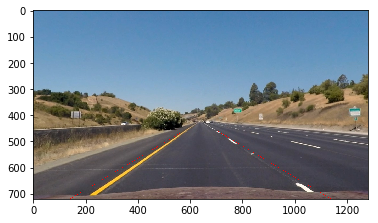

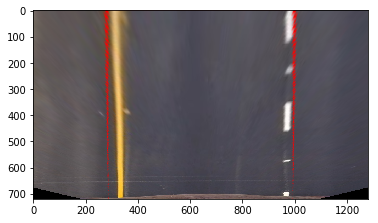

In [9]:
straightImage = cv2.imread('./test_images/straight_lines1.jpg')

#  available test images are straight_lines 1-2 and test 1-6
straightImageUndistorted = undistortImage(straightImage, objpoints, imgpoints)

plt.figure()

# Manually tune perspective transform values
img_height = straightImageUndistorted.shape[0]
img_width = straightImageUndistorted.shape[1]

topOffsetX = 0.45
topOffsetY = 0.64
topRight = [(img_width*(1-topOffsetX)) , img_height * topOffsetY]
topLeft = [img_width*topOffsetX, img_height * topOffsetY]

bottomOffset = 0.11
bottomRight = [(img_width*(1-bottomOffset)), img_height]
bottomLeft = [img_width*bottomOffset, img_height]

pts = np.array([topRight, bottomRight, bottomLeft, topLeft], np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(straightImageUndistorted, [pts], True, (0,0,255), thickness=1)
plt.imshow(cv2.cvtColor(straightImageUndistorted, cv2.COLOR_BGR2RGB))

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    # source pts needs better ones
    src = np.float32([topRight, bottomRight, bottomLeft, topLeft])
    
    middle = (img_width / 2)
    offset = middle * 0.55
    
    # destination pts
    dst = np.float32([[middle + offset, 0],
                      [middle + offset, img_height],
                      [middle - offset, img_height],
                      [middle - offset, 0]])
    
    # compute perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # compute inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # warp using perspective transform
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

straightImageUndistortedCopy = np.copy(straightImageUndistorted)
warpedImage = warp(straightImageUndistortedCopy)

# Plots the warped image to show the difference
plt.figure()
plt.imshow(cv2.cvtColor(warpedImage, cv2.COLOR_BGR2RGB))


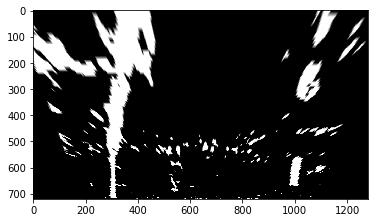

In [10]:
# [X] Apply a perspective transform to rectify binary image ("birds-eye view").
combinedTransformed = warp(combined)
plt.imshow(combinedTransformed, cmap='gray')
# [] Detect lane pixels and fit to find the lane boundary.






# [] Determine the curvature of the lane and vehicle position with respect to center.
# [] Warp the detected lane boundaries back onto the original image.
# [] Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

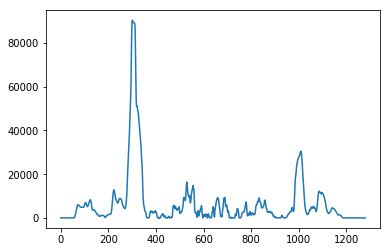

In [11]:
histogram = np.sum(combinedTransformed[combined.shape[0]//2:,:], axis=0)
plt.plot(histogram)

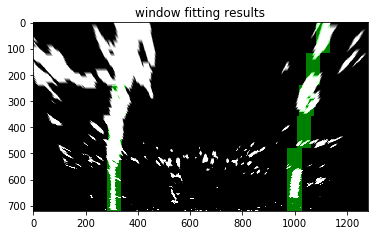

In [12]:
warped = np.copy(combinedTransformed)

# window settings
window_width = 55
window_height = 120 # Break image into 9 vertical layers since image height is 720
margin = 40 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together

        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green        
        
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
    #If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

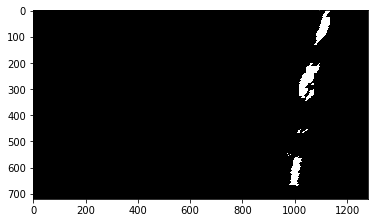

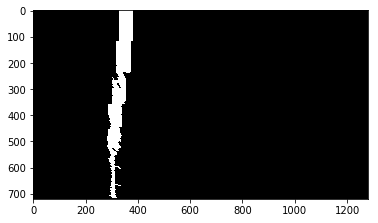

In [13]:
# [] Detect lane pixels and fit to find the lane boundary.

# get right lane pixels
r_pixels = np.zeros_like(combinedTransformed)
r_pixels[(r_points == 255) & (combinedTransformed == 255)] = 255
plt.figure()
plt.imshow(r_pixels, cmap='gray')

# get left lane pixels
l_pixels = np.zeros_like(combinedTransformed)
l_pixels[(l_points == 255) & (combinedTransformed == 255)] = 255
plt.figure()
plt.imshow(l_pixels, cmap='gray')











# [] Determine the curvature of the lane and vehicle position with respect to center.
# [] Warp the detected lane boundaries back onto the original image.
# [] Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

(720, 0)

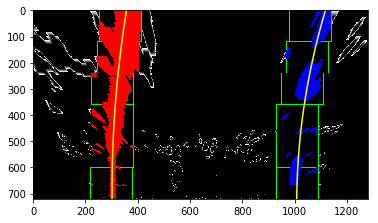

In [14]:
binary_warped = np.copy(combinedTransformed)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 6
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 80
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [15]:
print(left_lane_inds.shape)

(59303,)


In [16]:

#Now you know where the lines are you have a fit! In the next frame of video you don't 
#need to do a blind search again, but instead you can just search in a margin around the 
#previous line position like this:


# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 80
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



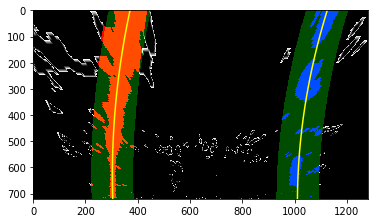

In [17]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))

# TODO: watch this
window_img_left = np.zeros_like(window_img)
cv2.fillPoly(window_img_left, np.int_([left_line_pts]), (0,255, 0))


cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

#TODO: watch this
window_img_right = np.zeros_like(window_img)
cv2.fillPoly(window_img_right, np.int_([right_line_pts]), (0,255, 0))


result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


#uhhh
orig_left_fitx = np.copy(left_fitx)
orig_right_fitx = np.copy(right_fitx)
orig_ploty = np.copy(ploty)



1777.94306798 1652.22013902
583.71315567 m 542.639325745 m


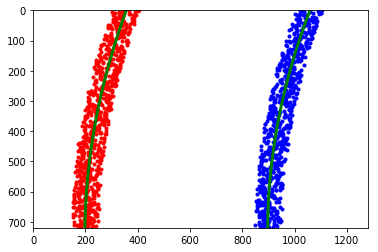

In [18]:
# [X] Detect lane pixels and fit to find the lane boundary.
# [] Determine the curvature of the lane and vehicle position with respect to center.


# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

# http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC tweek
# the 30 /3.7 values -- till better measurements
# assume 30 meters long and 3.7 meters wide
# 12 feet or 3.7 meters improve values later if needed

# Define conversions in x and y from pixels space to meters

y_tune = 30
x_tune = 3.7

ym_per_pix = y_tune/720 # meters per pixel in y dimension
xm_per_pix = x_tune/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


# [] Warp the detected lane boundaries back onto the original image.
# [] Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

583.71315567 m 542.639325745 m


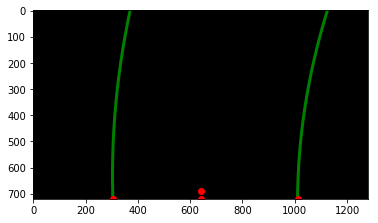

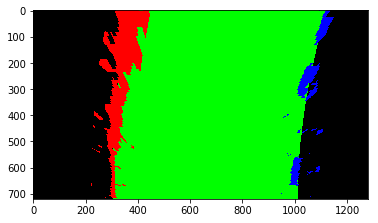

In [19]:
# [X] Detect lane pixels and fit to find the lane boundary.
# [] Determine the curvature of the lane and vehicle position with respect to center.

#respect to center? 20 , 3.7
#y_tune and x_tune
print(left_curverad, 'm', right_curverad, 'm')

#plt.figure()
#plt.imshow(window_img)

#orig_left_fitx = np.copy(left_fitx)
#orig_right_fitx = np.copy(left_fitx)
#orig_ploty = np.copy(ploty)

overlay = np.zeros_like(window_img)

plt.figure()
#color and linewidth
center_find_img = np.zeros_like(window_img)
plt.imshow(center_find_img)
plt.plot(orig_left_fitx, orig_ploty, color='green', linewidth=3)
plt.plot(orig_right_fitx, orig_ploty, color='green', linewidth=3)
plt.plot(orig_left_fitx[-1], orig_ploty[-1], 'ro')
plt.plot(orig_right_fitx[-1], orig_ploty[-1], 'ro')
plt.plot(window_img.shape[1] / 2, orig_ploty[-1], 'ro')
plt.plot(640, 690,'ro')



# could improve, assumes vehicle in lane and both lanes can be seen??
# returns string for vehicle position in meters
# takes in left, right and center pixels
# - is left + is right
#eyes on this maybe wrong
def getVehiclePosition(left, right, center):
    laneLength_pixels = right - left
    laneLength_meters = 3.7 # can tune this
    
    laneCenter = (left + right) / 2
    
    vehiclePosition_pixels = laneCenter - center # distance from lane center
    vehiclePosition_meters = (vehiclePosition_pixels * laneLength_meters) / laneLength_pixels
    
    return vehiclePosition_meters 

vehiclePos = (getVehiclePosition(orig_left_fitx[-1], orig_right_fitx[-1], window_img.shape[1] / 2))




left_points = np.column_stack((orig_left_fitx,orig_ploty))
right_points = np.column_stack((orig_right_fitx,orig_ploty))
right_rev = right_points[::-1]

points_combined = np.vstack((left_points, right_rev))

cv2.fillPoly(overlay, np.int_([points_combined]), (0,255, 0))

plt.figure()

overlay[(combinedTransformed == 255) & (window_img_right[:,:,1] == 255)] = (0,0,255)
overlay[(combinedTransformed == 255) & (window_img_left[:,:,1] == 255)] = (255,0,0)

plt.imshow(overlay)
# [] Warp the detected lane boundaries back onto the original image.




# [] Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [20]:
# TODO: cleanup old code
# TODO: modularize into functions
# test on individual images
# TODO: test on videos --try catch everything
# TODO: writeup

"""
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

"""

print('testing123')

testing123


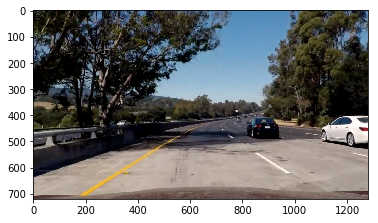

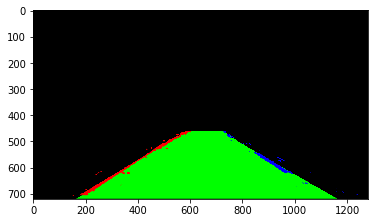

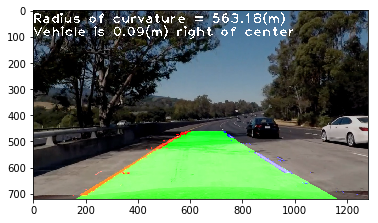

In [21]:
def unwarp(img, imgToUnwarp):
    img_size = (img.shape[1], img.shape[0])
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    # source pts needs better ones
    src = np.float32([topRight, bottomRight, bottomLeft, topLeft])
    
    middle = (img_width / 2)
    offset = middle * 0.55
    
    # destination pts
    dst = np.float32([[middle + offset, 0],
                      [middle + offset, img_height],
                      [middle - offset, img_height],
                      [middle - offset, 0]])
    
    # compute perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # compute inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # warp using perspective transform
    warped = cv2.warpPerspective(imgToUnwarp, Minv, img_size, flags=cv2.INTER_LINEAR)

    return warped

tmpOverlay = np.copy(overlay)

testingOver = np.zeros_like(overlay)
testingOver = unwarp(undistorted, tmpOverlay)


# [X] Warp the detected lane boundaries back onto the original image.

undisRGB = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
#lul = undisRGB + testingOver
lul = cv2.addWeighted(undisRGB, 0.8, testingOver, 1, 0.0) # tune dis sheet

plt.figure()
plt.imshow(undisRGB)

plt.figure()
plt.imshow(testingOver)

plt.figure()

# [] Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
# 0.8 is font scale, 3 is thickness, bttom line and ???line stuff

#Radius of curvature = 123(m)
#vehicle is 0.17m left of center

curvature = (left_curverad + right_curverad) / 2
curvatureStr = "Radius of curvature = " + str(round(curvature, 2)) + "(m)"
cv2.putText(lul, curvatureStr, (0, 50), 1, 3.5, (255, 255, 255), 4)



positionStr = ""

if vehiclePos >= 0:
    positionStr = "right"
else:
    positionStr = "left"


vehiclePosStr = "Vehicle is " + str(round(vehiclePos, 2)) + "(m) " + positionStr +" of center"
cv2.putText(lul, vehiclePosStr, (0, 100), 1, 3.5, (255, 255, 255), 4)



plt.imshow(lul)




In [22]:
# TODO: cleanup old code
# TODO: modularize into functions
# test on individual images
# TODO: test on videos --try catch everything
# TODO: writeup